In [1]:
#importing libraries

import numpy as np
import pandas as pd
import time
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
#import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt

In [2]:
# Versions
print("PyTorch version:    ", torch.__version__)
print("CUDA available:     ", torch.cuda.is_available())
#print("Intel Optimizations:", ipex.version.__version__)

PyTorch version:     1.12.1
CUDA available:      False


In [3]:
#settings
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 100
#If the GPU is available use it for the computation otherwise use the CPU
#DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

In [4]:
#importing dataset - Pytorch torchvision contains inbuilt datasets such as MNIST, FashionMNIST, CIFAR10 etc
#It will download the dataset first time
train_dataset = datasets.FashionMNIST(
root = './data',
download = True,
train = True,
transform = transforms.Compose([transforms.ToTensor()])
)

test_dataset = datasets.FashionMNIST(
root = './data',
download = True,
train = False,
transform = transforms.Compose([transforms.ToTensor()])
)

In [5]:
#data loader - We use dataLoader class from torch.utils.data to load data in batches

train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle= True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle= False)

In [6]:
#checking the dataset
for images, labels in train_loader:
    print('Image batch dimension:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimension: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


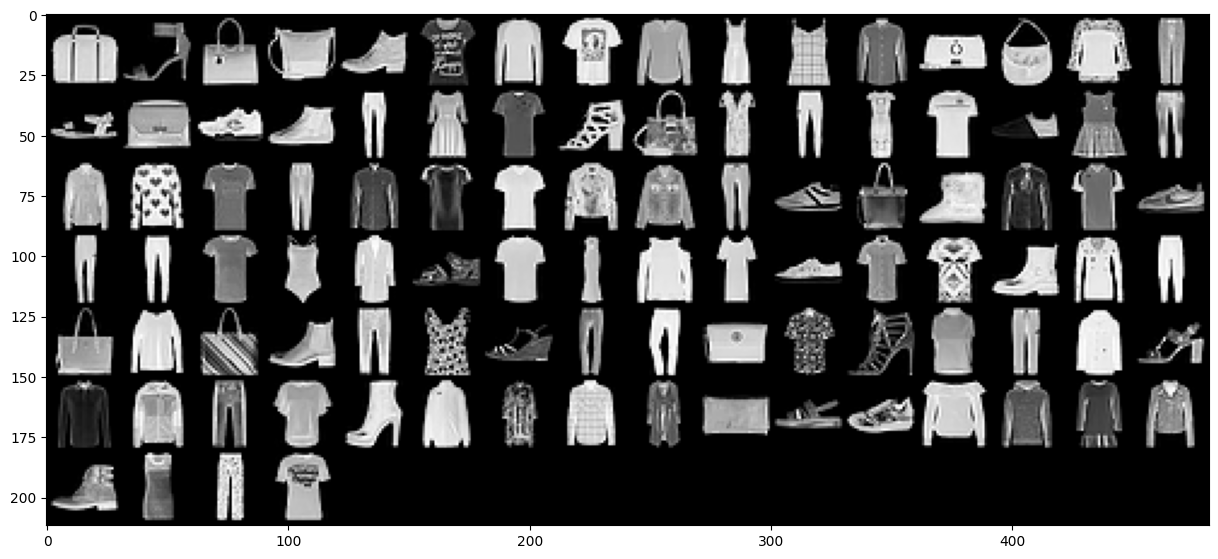

In [20]:
images, labels = next(iter(train_loader))
#used to create a grid of images
grid = torchvision.utils.make_grid(images,nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

In [8]:
class CNN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=60)
        self.out = torch.nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        # don't need softmax here since we'll use cross-entropy as activation.

        return t

In [9]:
#model initialization

torch.manual_seed(RANDOM_SEED)
model = CNN()

#model = model.to(DEVICE, memory_format=torch.channels_last)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [10]:
#Training

#computing loss for each epoch
def compute_loss (net, data_loader):
    curr_loss = 0.
    with torch.no_grad(): #disabled gradient, do not build computation graph as we are computing only loss no backward
        #Iterrating over dataloader, compute loss and add it up (instead of computing on whole dataset)
        for cnt, (features, targets) in enumerate (data_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            #logits, probas = net(features)
            logits = net(features)
            #loss = F.nll_loss(torch.log(probas), targets)
            #for more numerically stable
            loss = F.cross_entropy(logits, targets)
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    #model, optimizer = ipex.optimize(model, optimizer=optimizer)
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        #Forward and Back Prop
        #logits, probas = model(features)
        logits = model(features) #call forward

        #cost = F.nll_loss(torch.log(probas), targets)
        cost = F.cross_entropy(logits, targets) #corss entropy does log softmax
        optimizer.zero_grad() #set gradients from prev round to 0

        cost.backward() #call backward for back prop

        #Update model parameters
        optimizer.step()

        #Logging
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print('Epoch : %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost.item()))

    cost = compute_loss(model,train_loader)
    epoch_cost.append(cost)
    print('Epoch : %03d/%03d | Cost: %.4f' % (epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch : 001/100 | Batch 000/600 | Cost: 2.3083
Epoch : 001/100 | Batch 050/600 | Cost: 2.2631
Epoch : 001/100 | Batch 100/600 | Cost: 1.3695
Epoch : 001/100 | Batch 150/600 | Cost: 1.3284
Epoch : 001/100 | Batch 200/600 | Cost: 0.8975
Epoch : 001/100 | Batch 250/600 | Cost: 0.9044
Epoch : 001/100 | Batch 300/600 | Cost: 0.8088
Epoch : 001/100 | Batch 350/600 | Cost: 0.8113
Epoch : 001/100 | Batch 400/600 | Cost: 0.7378
Epoch : 001/100 | Batch 450/600 | Cost: 0.5889
Epoch : 001/100 | Batch 500/600 | Cost: 0.4073
Epoch : 001/100 | Batch 550/600 | Cost: 0.6637
Epoch : 001/100 | Cost: 0.5912
Time elapsed: 0.33 min
Epoch : 002/100 | Batch 000/600 | Cost: 0.5755
Epoch : 002/100 | Batch 050/600 | Cost: 0.5458
Epoch : 002/100 | Batch 100/600 | Cost: 0.5514
Epoch : 002/100 | Batch 150/600 | Cost: 0.6044
Epoch : 002/100 | Batch 200/600 | Cost: 0.5973
Epoch : 002/100 | Batch 250/600 | Cost: 0.5109
Epoch : 002/100 | Batch 300/600 | Cost: 0.4999
Epoch : 002/100 | Batch 350/600 | Cost: 0.5950
Epoch 

Epoch : 014/100 | Batch 200/600 | Cost: 0.3927
Epoch : 014/100 | Batch 250/600 | Cost: 0.1970
Epoch : 014/100 | Batch 300/600 | Cost: 0.1210
Epoch : 014/100 | Batch 350/600 | Cost: 0.2211
Epoch : 014/100 | Batch 400/600 | Cost: 0.2511
Epoch : 014/100 | Batch 450/600 | Cost: 0.1898
Epoch : 014/100 | Batch 500/600 | Cost: 0.3204
Epoch : 014/100 | Batch 550/600 | Cost: 0.2202
Epoch : 014/100 | Cost: 0.2564
Time elapsed: 4.78 min
Epoch : 015/100 | Batch 000/600 | Cost: 0.2385
Epoch : 015/100 | Batch 050/600 | Cost: 0.1692
Epoch : 015/100 | Batch 100/600 | Cost: 0.2062
Epoch : 015/100 | Batch 150/600 | Cost: 0.2596
Epoch : 015/100 | Batch 200/600 | Cost: 0.1981
Epoch : 015/100 | Batch 250/600 | Cost: 0.2315
Epoch : 015/100 | Batch 300/600 | Cost: 0.2063
Epoch : 015/100 | Batch 350/600 | Cost: 0.2846
Epoch : 015/100 | Batch 400/600 | Cost: 0.1777
Epoch : 015/100 | Batch 450/600 | Cost: 0.2417
Epoch : 015/100 | Batch 500/600 | Cost: 0.2272
Epoch : 015/100 | Batch 550/600 | Cost: 0.2466
Epoch 

Epoch : 027/100 | Batch 400/600 | Cost: 0.1937
Epoch : 027/100 | Batch 450/600 | Cost: 0.2163
Epoch : 027/100 | Batch 500/600 | Cost: 0.1472
Epoch : 027/100 | Batch 550/600 | Cost: 0.1871
Epoch : 027/100 | Cost: 0.1924
Time elapsed: 9.04 min
Epoch : 028/100 | Batch 000/600 | Cost: 0.2626
Epoch : 028/100 | Batch 050/600 | Cost: 0.1375
Epoch : 028/100 | Batch 100/600 | Cost: 0.1457
Epoch : 028/100 | Batch 150/600 | Cost: 0.1629
Epoch : 028/100 | Batch 200/600 | Cost: 0.1093
Epoch : 028/100 | Batch 250/600 | Cost: 0.1098
Epoch : 028/100 | Batch 300/600 | Cost: 0.1662
Epoch : 028/100 | Batch 350/600 | Cost: 0.1679
Epoch : 028/100 | Batch 400/600 | Cost: 0.2182
Epoch : 028/100 | Batch 450/600 | Cost: 0.1793
Epoch : 028/100 | Batch 500/600 | Cost: 0.1158
Epoch : 028/100 | Batch 550/600 | Cost: 0.2529
Epoch : 028/100 | Cost: 0.1802
Time elapsed: 9.42 min
Epoch : 029/100 | Batch 000/600 | Cost: 0.1386
Epoch : 029/100 | Batch 050/600 | Cost: 0.1530
Epoch : 029/100 | Batch 100/600 | Cost: 0.1227

Epoch : 040/100 | Cost: 0.1382
Time elapsed: 13.37 min
Epoch : 041/100 | Batch 000/600 | Cost: 0.2277
Epoch : 041/100 | Batch 050/600 | Cost: 0.0674
Epoch : 041/100 | Batch 100/600 | Cost: 0.0995
Epoch : 041/100 | Batch 150/600 | Cost: 0.1422
Epoch : 041/100 | Batch 200/600 | Cost: 0.1430
Epoch : 041/100 | Batch 250/600 | Cost: 0.1116
Epoch : 041/100 | Batch 300/600 | Cost: 0.0879
Epoch : 041/100 | Batch 350/600 | Cost: 0.2595
Epoch : 041/100 | Batch 400/600 | Cost: 0.1860
Epoch : 041/100 | Batch 450/600 | Cost: 0.0845
Epoch : 041/100 | Batch 500/600 | Cost: 0.1217
Epoch : 041/100 | Batch 550/600 | Cost: 0.0945
Epoch : 041/100 | Cost: 0.1468
Time elapsed: 13.71 min
Epoch : 042/100 | Batch 000/600 | Cost: 0.0780
Epoch : 042/100 | Batch 050/600 | Cost: 0.1188
Epoch : 042/100 | Batch 100/600 | Cost: 0.1236
Epoch : 042/100 | Batch 150/600 | Cost: 0.1396
Epoch : 042/100 | Batch 200/600 | Cost: 0.1920
Epoch : 042/100 | Batch 250/600 | Cost: 0.1716
Epoch : 042/100 | Batch 300/600 | Cost: 0.19

Epoch : 054/100 | Batch 100/600 | Cost: 0.1239
Epoch : 054/100 | Batch 150/600 | Cost: 0.1106
Epoch : 054/100 | Batch 200/600 | Cost: 0.1035
Epoch : 054/100 | Batch 250/600 | Cost: 0.0413
Epoch : 054/100 | Batch 300/600 | Cost: 0.2398
Epoch : 054/100 | Batch 350/600 | Cost: 0.1813
Epoch : 054/100 | Batch 400/600 | Cost: 0.1353
Epoch : 054/100 | Batch 450/600 | Cost: 0.1284
Epoch : 054/100 | Batch 500/600 | Cost: 0.0973
Epoch : 054/100 | Batch 550/600 | Cost: 0.2014
Epoch : 054/100 | Cost: 0.1074
Time elapsed: 18.12 min
Epoch : 055/100 | Batch 000/600 | Cost: 0.0881
Epoch : 055/100 | Batch 050/600 | Cost: 0.2204
Epoch : 055/100 | Batch 100/600 | Cost: 0.0497
Epoch : 055/100 | Batch 150/600 | Cost: 0.0379
Epoch : 055/100 | Batch 200/600 | Cost: 0.0838
Epoch : 055/100 | Batch 250/600 | Cost: 0.0829
Epoch : 055/100 | Batch 300/600 | Cost: 0.1097
Epoch : 055/100 | Batch 350/600 | Cost: 0.1326
Epoch : 055/100 | Batch 400/600 | Cost: 0.0988
Epoch : 055/100 | Batch 450/600 | Cost: 0.1037
Epoch

Epoch : 067/100 | Batch 300/600 | Cost: 0.0651
Epoch : 067/100 | Batch 350/600 | Cost: 0.0811
Epoch : 067/100 | Batch 400/600 | Cost: 0.1019
Epoch : 067/100 | Batch 450/600 | Cost: 0.0676
Epoch : 067/100 | Batch 500/600 | Cost: 0.1307
Epoch : 067/100 | Batch 550/600 | Cost: 0.1659
Epoch : 067/100 | Cost: 0.1638
Time elapsed: 22.47 min
Epoch : 068/100 | Batch 000/600 | Cost: 0.1254
Epoch : 068/100 | Batch 050/600 | Cost: 0.0281
Epoch : 068/100 | Batch 100/600 | Cost: 0.0434
Epoch : 068/100 | Batch 150/600 | Cost: 0.0776
Epoch : 068/100 | Batch 200/600 | Cost: 0.0598
Epoch : 068/100 | Batch 250/600 | Cost: 0.1113
Epoch : 068/100 | Batch 300/600 | Cost: 0.0799
Epoch : 068/100 | Batch 350/600 | Cost: 0.0875
Epoch : 068/100 | Batch 400/600 | Cost: 0.0946
Epoch : 068/100 | Batch 450/600 | Cost: 0.0138
Epoch : 068/100 | Batch 500/600 | Cost: 0.1416
Epoch : 068/100 | Batch 550/600 | Cost: 0.0717
Epoch : 068/100 | Cost: 0.0814
Time elapsed: 22.78 min
Epoch : 069/100 | Batch 000/600 | Cost: 0.08

Epoch : 080/100 | Batch 500/600 | Cost: 0.1338
Epoch : 080/100 | Batch 550/600 | Cost: 0.0861
Epoch : 080/100 | Cost: 0.0652
Time elapsed: 26.52 min
Epoch : 081/100 | Batch 000/600 | Cost: 0.0883
Epoch : 081/100 | Batch 050/600 | Cost: 0.0672
Epoch : 081/100 | Batch 100/600 | Cost: 0.1177
Epoch : 081/100 | Batch 150/600 | Cost: 0.0609
Epoch : 081/100 | Batch 200/600 | Cost: 0.1208
Epoch : 081/100 | Batch 250/600 | Cost: 0.0620
Epoch : 081/100 | Batch 300/600 | Cost: 0.0669
Epoch : 081/100 | Batch 350/600 | Cost: 0.1018
Epoch : 081/100 | Batch 400/600 | Cost: 0.0071
Epoch : 081/100 | Batch 450/600 | Cost: 0.0953
Epoch : 081/100 | Batch 500/600 | Cost: 0.0699
Epoch : 081/100 | Batch 550/600 | Cost: 0.1187
Epoch : 081/100 | Cost: 0.0629
Time elapsed: 26.84 min
Epoch : 082/100 | Batch 000/600 | Cost: 0.0478
Epoch : 082/100 | Batch 050/600 | Cost: 0.0791
Epoch : 082/100 | Batch 100/600 | Cost: 0.0912
Epoch : 082/100 | Batch 150/600 | Cost: 0.0888
Epoch : 082/100 | Batch 200/600 | Cost: 0.04

Epoch : 094/100 | Batch 050/600 | Cost: 0.0471
Epoch : 094/100 | Batch 100/600 | Cost: 0.0574
Epoch : 094/100 | Batch 150/600 | Cost: 0.0441
Epoch : 094/100 | Batch 200/600 | Cost: 0.0421
Epoch : 094/100 | Batch 250/600 | Cost: 0.0413
Epoch : 094/100 | Batch 300/600 | Cost: 0.0286
Epoch : 094/100 | Batch 350/600 | Cost: 0.1329
Epoch : 094/100 | Batch 400/600 | Cost: 0.1106
Epoch : 094/100 | Batch 450/600 | Cost: 0.0301
Epoch : 094/100 | Batch 500/600 | Cost: 0.0574
Epoch : 094/100 | Batch 550/600 | Cost: 0.1792
Epoch : 094/100 | Cost: 0.0538
Time elapsed: 30.97 min
Epoch : 095/100 | Batch 000/600 | Cost: 0.0273
Epoch : 095/100 | Batch 050/600 | Cost: 0.0477
Epoch : 095/100 | Batch 100/600 | Cost: 0.0858
Epoch : 095/100 | Batch 150/600 | Cost: 0.0836
Epoch : 095/100 | Batch 200/600 | Cost: 0.0429
Epoch : 095/100 | Batch 250/600 | Cost: 0.0420
Epoch : 095/100 | Batch 300/600 | Cost: 0.0397
Epoch : 095/100 | Batch 350/600 | Cost: 0.0785
Epoch : 095/100 | Batch 400/600 | Cost: 0.0621
Epoch

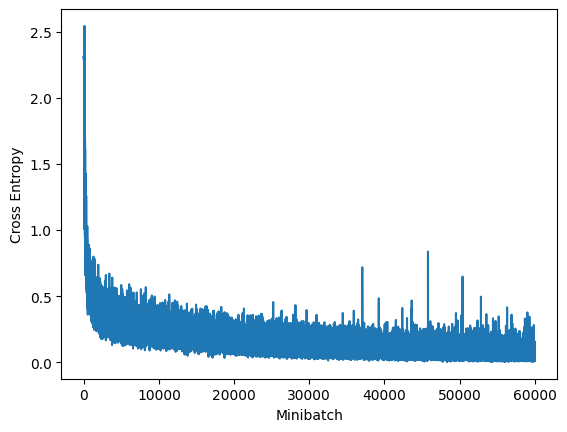

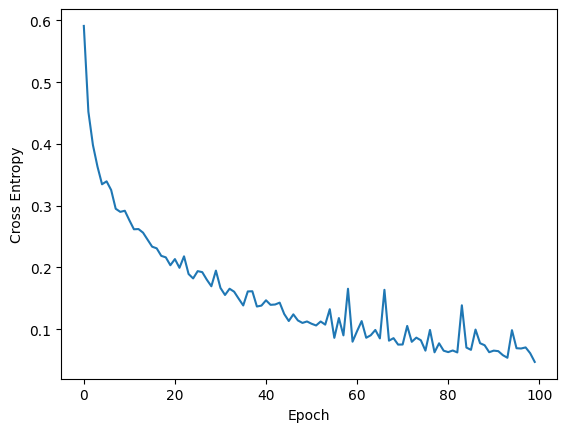

In [11]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 98.24
Test Accuracy: 88.54


In [13]:
print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.fc1.weight.shape)
print(model.fc2.weight.shape)
print(model.out.weight.shape)

torch.Size([6, 1, 5, 5])
torch.Size([12, 6, 5, 5])
torch.Size([120, 192])
torch.Size([60, 120])
torch.Size([10, 60])


In [14]:
with open("output/cnn_conv1_weights.npy", "wb") as f:
    np.save(f, model.conv1.weight.detach().numpy(), False)
with open("output/cnn_conv1_bias.npy", "wb") as f:
    np.save(f, model.conv1.bias.detach().numpy(), False)

with open("output/cnn_conv2_weights.npy", "wb") as f:
    np.save(f, model.conv2.weight.detach().numpy(), False)
with open("output/cnn_conv2_bias.npy", "wb") as f:
    np.save(f, model.conv2.bias.detach().numpy(), False)

with open("output/cnn_l1_weights.npy", "wb") as f:
    np.save(f, model.fc1.weight.detach().numpy(), False)
with open("output/cnn_l1_bias.npy", "wb") as f:
    np.save(f, model.fc1.bias.detach().numpy(), False)

with open("output/cnn_l2_weights.npy", "wb") as f:
    np.save(f, model.fc2.weight.detach().numpy(), False)
with open("output/cnn_l2_bias.npy", "wb") as f:
    np.save(f, model.fc2.bias.detach().numpy(), False)

with open("output/cnn_l3_weights.npy", "wb") as f:
    np.save(f, model.out.weight.detach().numpy(), False)
with open("output/cnn_l3_bias.npy", "wb") as f:
    np.save(f, model.out.bias.detach().numpy(), False)

In [22]:
torch.save(model,"output/saved_cnn_model.pt")

In [23]:
model2 = torch.load("output/saved_cnn_model.pt")
model2.eval()

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)